In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-krfrkt6g
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-krfrkt6g
  Created wheel for tensorflow-examples: filename=tensorflow_examples-3fa70c493999e348c4458f3d3b7ba3a747a6b9cc_-cp36-none-any.whl size=131269 sha256=a2332796b4f71d7004ec8622f34e5b3ea4d733be1f577c0503caf177b9055b9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-rhz945y7/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import PIL
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from keras.preprocessing.image import ImageDataGenerator
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output,Image

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

Using TensorFlow backend.


In [ ]:
import cv2

In [ ]:
train_datagen=ImageDataGenerator()
blur_set = train_datagen.flow_from_directory('/content/drive/My Drive/f2',
                                                    target_size = (256,256),
                                                    batch_size = 1,
                                                    class_mode=None)

Found 350 images belonging to 1 classes.


In [ ]:
train1_datagen=ImageDataGenerator()
sharp_set = train_datagen.flow_from_directory('/content/drive/My Drive/f1',
                                                    target_size = (256,256),
                                                    batch_size = 1,
                                                    class_mode=None)

Found 350 images belonging to 1 classes.


In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 3

In [ ]:
def generate_images(image):
  #prediction = model(test_input)
  prediction = generator_g(blur_set[0]) 
  plt.figure(figsize=(12, 12))

  display_list = [image[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:

def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for i in range(350):
    image_x=blur_set[i]
    image_y=sharp_set[i]
    train_step(image_x,image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Time taken for epoch 3 is 5238.266620159149 sec



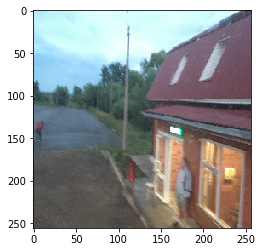

In [ ]:
npArray = np.array(blur_set[0][0], dtype='uint8')
plt.imshow(npArray, interpolation='nearest')
plt.show()

In [ ]:
deblur=generator_g(blur_set[0])

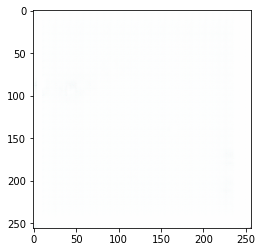

In [ ]:
plt.imshow((generator_f(deblur)[0]))

In [ ]:
type(deblur)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
from IPython import display

In [ ]:
im=display.Image(deblur)

TypeError: ignored

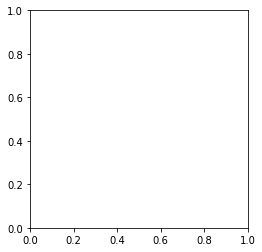

In [ ]:
plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


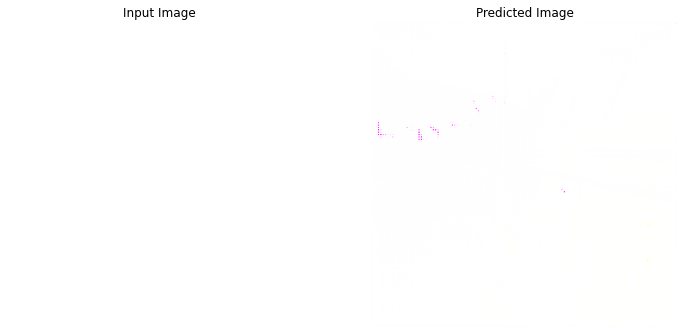

In [ ]:
generate_images(blur_set[0])

In [ ]:
deblur[0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[1.        , 0.9999265 , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 0.9999989 , 1.        ],
        ...,
        [0.99990445, 1.        , 0.9999819 ],
        [1.        , 0.99760944, 1.        ],
        [0.5278873 , 0.9994367 , 0.99740773]],

       [[1.        , 0.9999988 , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.999977  , 0.9999996 , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.9936915 , 0.99992263, 1.        ]],

       ...,

       [[1.        , 0.99864095, 0.999996  ],
        [1.  

In [ ]:
from cv2 import imshow

In [ ]:
d=tf.cast(deblur,tf.float32)

In [ ]:
type(d)

tensorflow.python.framework.ops.EagerTensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


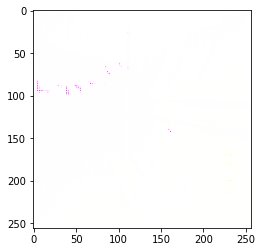

In [ ]:
plt.imshow(d[0])